# Dimensionality Reduction Starter Coder Week 4
# This version includes TFIDF, Word2Vec, Doc2Vec, LSA, and LDA code
# In Version 3 we also included coherence measures 
# and a bit more code related to SVD
# 2021WI_MSDS_453-DL_SEC56
# paulhuynh2018@u.northwestern.edu, jennifer.sleeman@northwestern.edu

In [38]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel, CoherenceModel
from gensim import corpora
from gensim import similarities


from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim.models import LsiModel,LdaModel
import seaborn as sns

import numpy as np
import pyLDAvis

import pickle 

import warnings
warnings.filterwarnings('ignore')
# Visualize the topics
pyLDAvis.enable_notebook()

In [8]:
#functions used to process text and create the required TFIDF and Doc2vec Matrices
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc


In [9]:
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix, words

In [10]:
#This is code for Week 4.  The code will go consist of 4 sections as follows:
#1. Latent Semantic Analysis Example
#2. Latent Dirichlet Allocation
#3. Word2Vec Matrix creation

In [11]:

#Section 1: Latent Semantic Analysis Using Gensim's implementation
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index



In [12]:
#Section 1: Latent Semantic Analysis Example
def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)

    LSA.fit(tfidf_matrix)


    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])



In [13]:
#Section 2: Latent Dirichlet Allocation
def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

In [14]:
#Section 3: Word2Vec Matrix Generation
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df


In [17]:
#this section of the code prepares the required variables to run functions set for each 
#section of code

#read in class corpus csv into python
data=pd.read_csv(r'/Users/paulhuynh/Documents/School/Code_for_SS/2021_Spring_453_Sec56_Class_Corpus-4.csv')

#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))



#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()


In [34]:
def plot_lsa(number_of_topics, words):

    ######################################
    #Function to plot the LSA based on user defined numbrer of topics and words
    #EXPERIMENT WITH THESE PARAMETERS topics and words

    #####################################
    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model
    

[(0, '0.433*"movie" + 0.217*"story" + 0.149*"first" + 0.141*"world" + 0.127*"something" + 0.122*"disney" + 0.107*"still" + 0.103*"young" + 0.103*"films" + 0.099*"human"'), (1, '0.304*"movie" + -0.214*"digital" + -0.196*"bridges" + -0.195*"original" + -0.175*"legacy" + -0.174*"flynn" + -0.172*"kevin" + -0.159*"soundtrack" + -0.153*"world" + -0.140*"father"'), (2, '-0.363*"disney" + -0.180*"remake" + -0.149*"jungle" + -0.144*"mulan" + 0.142*"young" + -0.135*"movie" + -0.119*"mowgli" + -0.119*"article" + 0.117*"robot" + -0.112*"songs"'), (3, '-0.364*"rocky" + -0.331*"first" + -0.195*"stallone" + -0.163*"coogler" + -0.163*"donny" + 0.161*"computer" + 0.140*"robot" + 0.116*"human" + 0.113*"movie" + 0.107*"digital"'), (4, '0.290*"dhoni" + -0.248*"robot" + -0.205*"human" + 0.185*"cricket" + -0.159*"robots" + -0.142*"rocky" + -0.133*"space" + 0.132*"singh" + -0.120*"spooner" + 0.106*"rajput"'), (5, '-0.405*"family" + -0.245*"witch" + 0.200*"computer" + -0.146*"thomasin" + 0.142*"rocky" + 0.130

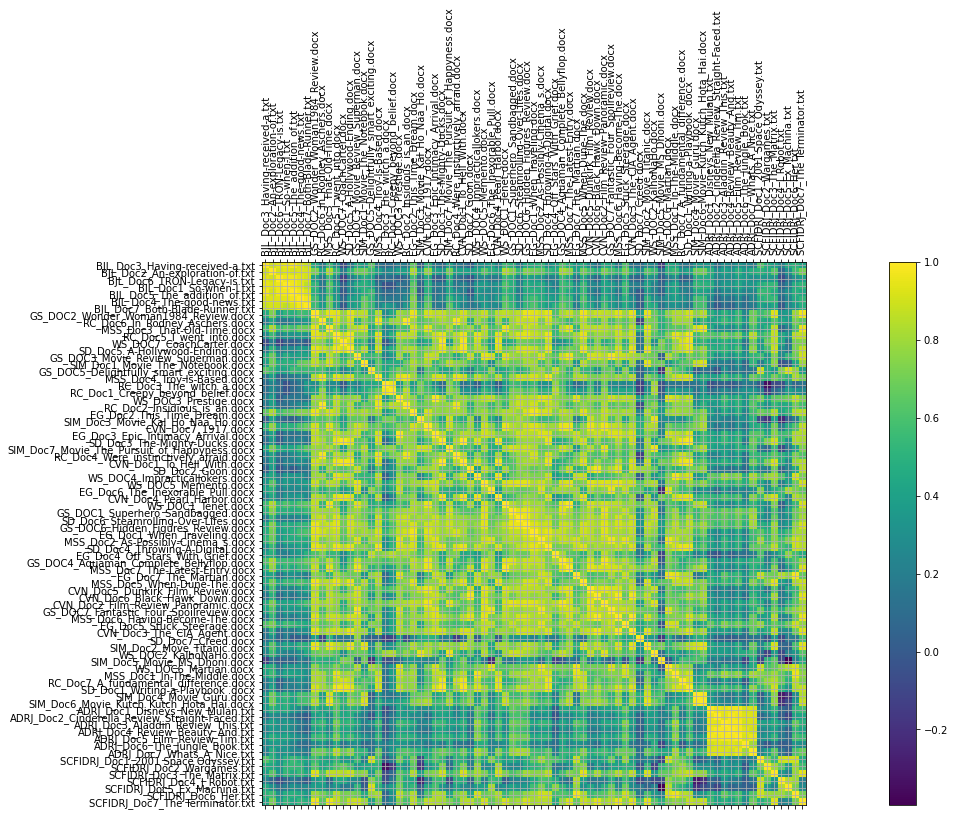

In [39]:
#plotting 6 topics and 10 words
model_6topic_10words = plot_lsa(6, 10)

[(0, '0.433*"movie" + 0.217*"story" + 0.149*"first" + 0.141*"world" + 0.127*"something" + 0.122*"disney" + 0.107*"still" + 0.103*"young" + 0.103*"films" + 0.099*"human"'), (1, '0.304*"movie" + -0.214*"digital" + -0.196*"bridges" + -0.195*"original" + -0.175*"legacy" + -0.174*"flynn" + -0.172*"kevin" + -0.159*"soundtrack" + -0.153*"world" + -0.140*"father"')]


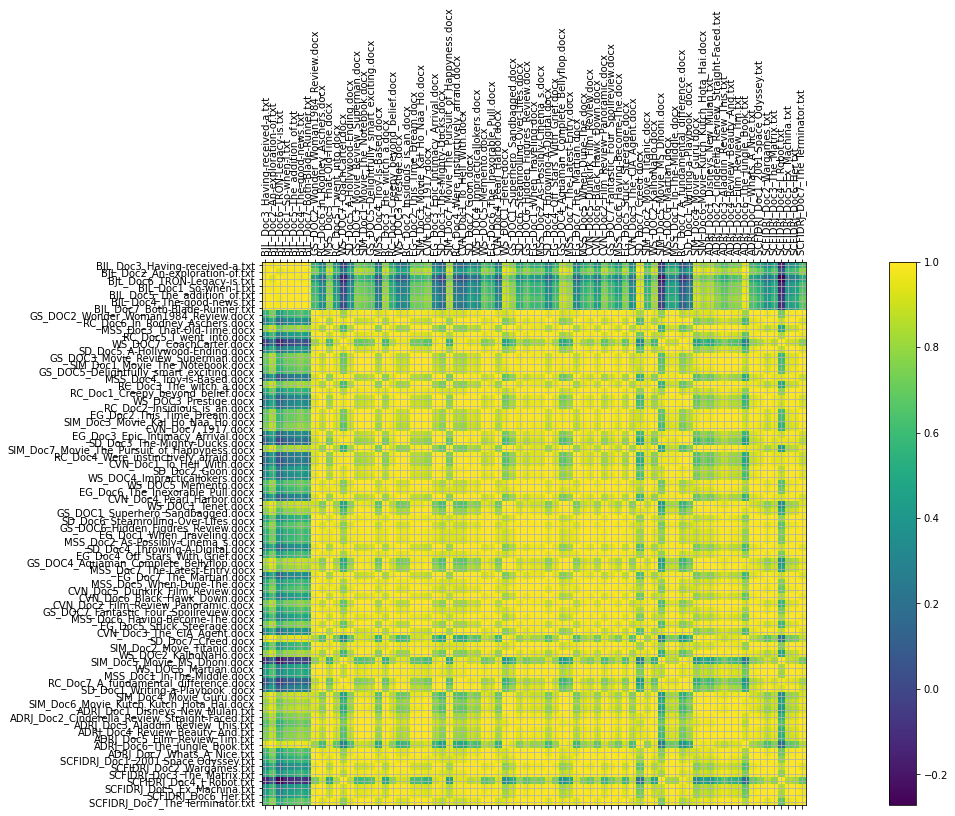

In [40]:
#plotting 2 topics and 10 words
model_2topic_10words = plot_lsa(2, 10)

[(0, '0.433*"movie" + 0.217*"story" + 0.149*"first" + 0.141*"world" + 0.127*"something" + 0.122*"disney" + 0.107*"still" + 0.103*"young" + 0.103*"films" + 0.099*"human"'), (1, '-0.304*"movie" + 0.214*"digital" + 0.196*"bridges" + 0.195*"original" + 0.175*"legacy" + 0.174*"flynn" + 0.172*"kevin" + 0.159*"soundtrack" + 0.153*"world" + 0.140*"father"'), (2, '0.363*"disney" + 0.180*"remake" + 0.149*"jungle" + 0.144*"mulan" + -0.142*"young" + 0.135*"movie" + 0.119*"mowgli" + 0.119*"article" + -0.117*"robot" + 0.112*"songs"'), (3, '0.364*"rocky" + 0.331*"first" + 0.195*"stallone" + 0.163*"donny" + 0.163*"coogler" + -0.161*"computer" + -0.140*"robot" + -0.116*"human" + -0.113*"movie" + -0.107*"digital"'), (4, '-0.290*"dhoni" + 0.248*"robot" + 0.205*"human" + -0.185*"cricket" + 0.159*"robots" + 0.142*"rocky" + 0.133*"space" + -0.132*"singh" + 0.120*"spooner" + -0.106*"rajput"'), (5, '0.405*"family" + 0.245*"witch" + -0.200*"computer" + 0.146*"thomasin" + -0.142*"rocky" + -0.130*"dhoni" + -0.11

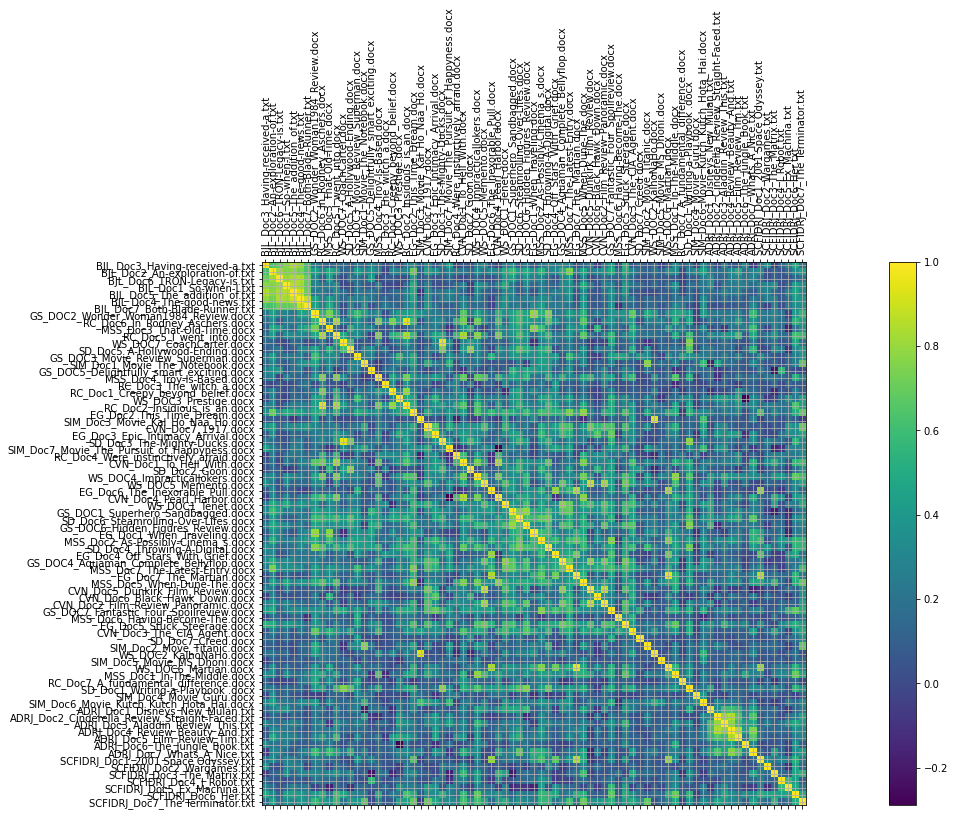

In [41]:
#plotting 20 topics and 10 words
model_20topic_10words =plot_lsa(20, 10)

In [53]:
#compare LSA model coherence

topics = [6, 2, 10]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '0.433*"movie" + 0.217*"story" + 0.149*"first" + 0.141*"world" + 0.127*"something" + 0.122*"disney" + 0.107*"still" + 0.103*"young" + 0.103*"films" + 0.099*"human"'), (1, '0.304*"movie" + -0.214*"digital" + -0.196*"bridges" + -0.195*"original" + -0.175*"legacy" + -0.174*"flynn" + -0.172*"kevin" + -0.159*"soundtrack" + -0.153*"world" + -0.140*"father"'), (2, '-0.363*"disney" + -0.180*"remake" + -0.149*"jungle" + -0.144*"mulan" + 0.142*"young" + -0.135*"movie" + -0.119*"mowgli" + -0.119*"article" + 0.117*"robot" + -0.112*"songs"'), (3, '-0.364*"rocky" + -0.331*"first" + -0.195*"stallone" + -0.163*"coogler" + -0.163*"donny" + 0.161*"computer" + 0.140*"robot" + 0.116*"human" + 0.113*"movie" + 0.107*"digital"'), (4, '0.290*"dhoni" + -0.248*"robot" + -0.205*"human" + 0.185*"cricket" + -0.159*"robots" + -0.142*"rocky" + -0.133*"space" + 0.132*"singh" + -0.120*"spooner" + 0.106*"untold"'), (5, '-0.405*"family" + -0.245*"witch" + 0.200*"computer" + -0.146*"thomasin" + 0.142*"rocky" + 0.130

In [61]:
#Section 2:  Latent Dirichlet Allocation Using Gensim's implementation
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])



    return ldamodel,dictionary,index,doc_term_matrix



[(0, '0.006*"movie" + 0.004*"story" + 0.002*"world" + 0.002*"first" + 0.002*"family" + 0.002*"something" + 0.002*"young" + 0.002*"films" + 0.002*"looks" + 0.001*"movies"'), (1, '0.008*"movie" + 0.004*"story" + 0.003*"disney" + 0.003*"first" + 0.002*"world" + 0.002*"something" + 0.002*"films" + 0.002*"digital" + 0.002*"still" + 0.002*"original"'), (2, '0.005*"movie" + 0.002*"first" + 0.002*"story" + 0.002*"young" + 0.002*"human" + 0.002*"would" + 0.002*"something" + 0.001*"world" + 0.001*"plays" + 0.001*"movies"'), (3, '0.005*"movie" + 0.003*"story" + 0.003*"world" + 0.003*"family" + 0.003*"first" + 0.002*"though" + 0.002*"young" + 0.002*"something" + 0.002*"father" + 0.002*"human"'), (4, '0.006*"movie" + 0.003*"story" + 0.003*"still" + 0.002*"first" + 0.002*"world" + 0.002*"young" + 0.002*"another" + 0.002*"something" + 0.002*"little" + 0.002*"never"'), (5, '0.007*"movie" + 0.003*"story" + 0.003*"first" + 0.002*"world" + 0.002*"space" + 0.002*"though" + 0.002*"human" + 0.002*"little" +

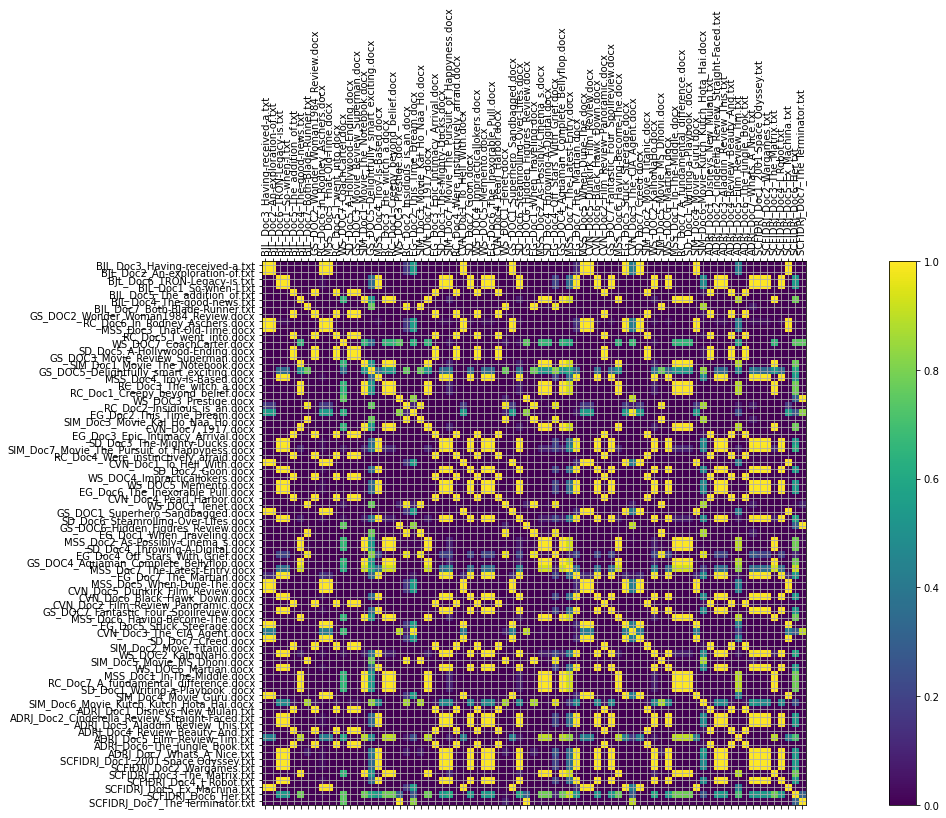

In [63]:
#run section 2
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=6
words=10
#####################################
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model( processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

In [64]:
#compare LSA model coherence

topics = [6, 2, 10]
coherence_values = []
for t in topics:
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    
coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '0.005*"movie" + 0.003*"first" + 0.003*"story" + 0.002*"films" + 0.002*"world" + 0.002*"something" + 0.002*"title" + 0.002*"disney" + 0.002*"family" + 0.002*"young"'), (1, '0.007*"movie" + 0.003*"first" + 0.003*"story" + 0.002*"young" + 0.002*"world" + 0.002*"space" + 0.002*"something" + 0.002*"still" + 0.002*"played" + 0.002*"movies"'), (2, '0.004*"movie" + 0.003*"story" + 0.002*"human" + 0.002*"world" + 0.002*"might" + 0.002*"first" + 0.002*"films" + 0.002*"around" + 0.002*"another" + 0.002*"naina"'), (3, '0.008*"movie" + 0.003*"world" + 0.003*"story" + 0.003*"something" + 0.003*"still" + 0.002*"digital" + 0.002*"first" + 0.002*"original" + 0.002*"bridges" + 0.002*"would"'), (4, '0.008*"movie" + 0.004*"story" + 0.003*"though" + 0.002*"first" + 0.002*"family" + 0.002*"world" + 0.002*"disney" + 0.002*"enough" + 0.002*"space" + 0.002*"still"'), (5, '0.005*"movie" + 0.004*"story" + 0.002*"first" + 0.002*"young" + 0.002*"might" + 0.002*"world" + 0.002*"little" + 0.002*"something" + 0